# Web Scraping ETnet HSI Index Constituent data
https://www.etnet.com.hk/www/eng/stocks/indexes_detail.php?subtype=HSI
<BR>https://www.etnet.com.hk/robots.txt

In [1]:
from bs4 import BeautifulSoup as bs
from tqdm import tqdm
import yfinance as yf
import requests
import pandas as pd
import numpy as np
import plotly.express as px
from plotly.offline import plot
#yf.__version__

# Utilities functions

In [2]:
def convert2yf(code: str) -> str: 
    """Convert stockcode to yFinance format"""
    return (4 - len(str(int(code)))) * '0' + str(int(code)) +'.HK'
convert2yf('00001')

'0001.HK'

In [3]:
def yfData(ticker:str, dataCol: str) :
    """Search fundamental data from yFinance"""
    return yf.Ticker(ticker).info[dataCol]
yfData('0001.HK', 'ebitda')

47850000384

# Web Scraping HSI constituents data from ETnet

In [4]:
url = "https://www.etnet.com.hk/www/eng/stocks/indexes_detail.php?subtype=HSI"

headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
# requests.get(url, headers=headers)

In [5]:
try:
    hsiConst = requests.get(url, headers=headers)
    if hsiConst.status_code == 200:
        print('Connect successfully!')
        hsi = bs(hsiConst.content, 'html.parser')
    else:
        print("Connect failed. Status code:",hsiConst.status_code)
except Exception as e:
    print('Failed to connect. ', e)

Connect successfully!


In [6]:
# one row of target data
for tr in hsi.findAll('tr', {"valign":"middle"}):
    print(tr.findAll('a')[0].text, 
          tr.findAll('a')[1].text, 
          tr.findAll('td',{"align":"right"})[1].text,
          tr.findAll('td',{"align":"right"})[3].text,)
    break

00001 CKH HOLDINGS 52.550 +1.742%


In [7]:
ticker, company, close, pctChange = [], [], [], []
for tr in hsi.find_all('tr', {"valign":"middle"}):
    ticker.append(convert2yf(tr.find_all('a')[0].text))
    company.append(tr.find_all('a')[1].text)
    close.append(float(tr.find_all('td',{"align":"right"})[1].text))
    pctChange.append(tr.find_all('td',{"align":"right"})[3].text)

df = pd.DataFrame({'Ticker': ticker, 'Company': company, 'Close': close, 'PctChange': pctChange})
df.head(3)

,Ticker,Company,Close,PctChange
0,0001.HK,CKH HOLDINGS,53.00,-1.852%
1,0002.HK,CLP HOLDINGS,69.95,+0.072%
2,0003.HK,HK & CHINA GAS,7.11,0.000%


In [8]:
# add hover display
df['Display'] = df.apply(lambda df : f"<BR>{df['Company']}<BR>{df['PctChange']}<BR><a href='https://finance.yahoo.com/quote/{df['Ticker']}/'>quote {df['Ticker']}</a>",  axis=1)

In [9]:
# change datatype of pctChange
df['changeRange'] = pd.cut(df['PctChange'].str.replace("%","").astype(float),  bins=[float('-Inf'), -4, -3, -2, -1, -0.5, +0.5, +1, +2, +3, +4, float('Inf')],
       labels=['<-4%', '-3%', '-2%', '-1%', '-0.5%','0%', '+0.5%', '+1%', '+2%', '+3%', '>+4%'])
# Add the "(?)" category to handle any missing values or edge cases
df['changeRange'] = df['changeRange'].cat.add_categories(['(?)'])
df['changeRange'] = df['changeRange'].fillna('(?)')

# Add fundamental data from yFinance

In [10]:
%%time
# Do not run the following code too often. Rate limited might occur.
for data in tqdm(['marketCap',
                    'volume',
                    'sharesOutstanding',
                    # 'fiftyTwoWeekHigh',
                    # 'fiftyTwoWeekLow',
                    'epsTrailingTwelveMonths',
                    'bookValue',
                    # 'revenuePerShare',
                    # 'targetHighPrice',
                    # 'targetLowPrice',
                    # 'targetMeanPrice',
                    # 'targetMedianPrice'
                 ], desc="preparing...") :
    df[data] = df['Ticker'].apply(yfData, dataCol=data)

preparing...: 100%|███████████████████████████████| 5/5 [02:57<00:00, 35.52s/it]

CPU times: user 1.37 s, sys: 174 ms, total: 1.55 s
Wall time: 2min 57s


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Ticker                   89 non-null     object  
 1   Company                  89 non-null     object  
 2   Close                    89 non-null     float64 
 3   PctChange                89 non-null     object  
 4   Display                  89 non-null     object  
 5   changeRange              89 non-null     category
 6   marketCap                89 non-null     int64   
 7   volume                   89 non-null     int64   
 8   sharesOutstanding        89 non-null     int64   
 9   epsTrailingTwelveMonths  89 non-null     float64 
 10  bookValue                89 non-null     float64 
dtypes: category(1), float64(3), int64(3), object(4)
memory usage: 7.6+ KB


In [12]:
df['PE'] = df.Close / df.epsTrailingTwelveMonths
df['PB'] = df.Close / df.bookValue
df.sample(5)

,Ticker,Company,Close,PctChange,Display,changeRange,marketCap,volume,sharesOutstanding,epsTrailingTwelveMonths,bookValue,PE,PB
59,2015.HK,LI AUTO-W,66.70,-1.984%,<BR>LI AUTO-W<BR>-1.984%<BR><a href='https://f...,-1%,134868148224,6345872,1670756442,4.24,80.223495,15.731132,0.831427
15,0288.HK,WH GROUP,8.65,-0.575%,<BR>WH GROUP<BR>-0.575%<BR><a href='https://fi...,-0.5%,111238004736,7182753,12830219550,0.98,6.638875,8.826531,1.302932
18,0316.HK,OOIL,125.30,-1.339%,<BR>OOIL<BR>-1.339%<BR><a href='https://financ...,-1%,82480627712,389805,660373297,31.75,157.213550,3.946457,0.797005
48,1209.HK,CHINA RES MIXC,43.88,+1.904%,<BR>CHINA RES MIXC<BR>+1.904%<BR><a href='http...,+1%,100156104704,476800,2282500000,1.84,7.585322,23.847826,5.784857
30,0868.HK,XINYI GLASS,8.64,+1.767%,<BR>XINYI GLASS<BR>+1.767%<BR><a href='https:/...,+1%,38135820288,3511312,4424108852,0.48,8.948875,18.000000,0.965484


# Plot Treemap

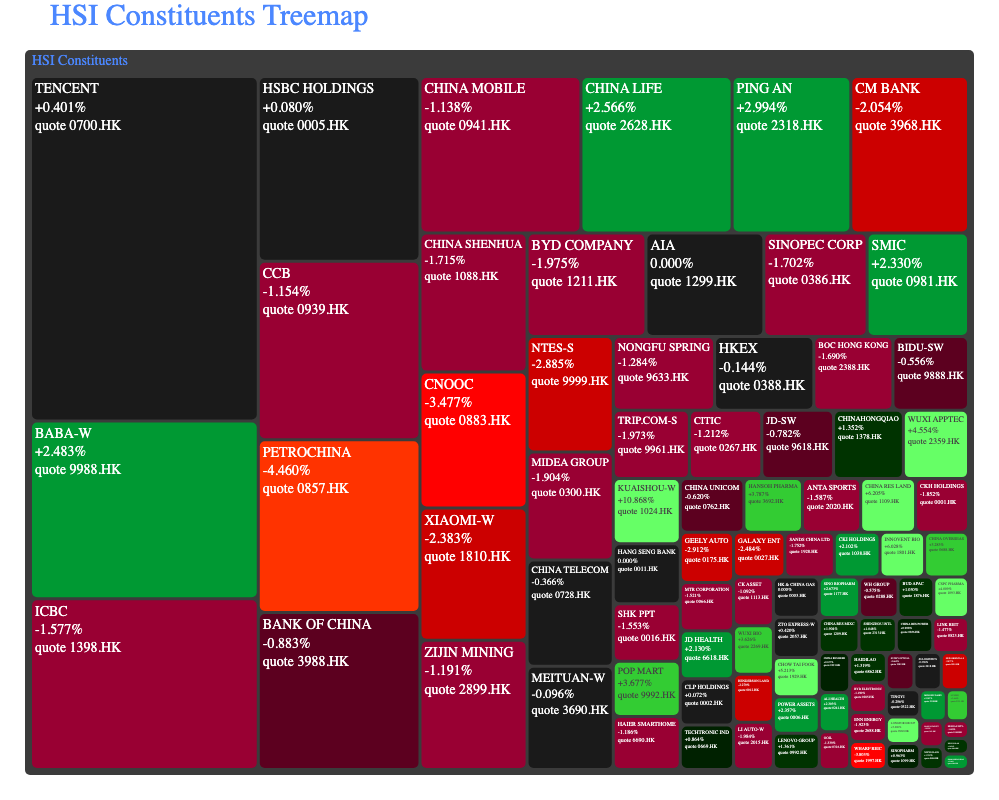

In [13]:
fig = px.treemap(df, path=[ px.Constant("HSI Constituents"),'Display' ],  
                values='marketCap', color='changeRange',  height=800,
                color_discrete_map={'(?)':'#3b3b3b', '<-4%':'#ff3300', '-3%':'#ff0000', '-2%':'#cc0000', '-1%':'#990033', '-0.5%':'#5c001f',
                                    '0%':'#1a1a1a', '+0.5%':'#002100', '+1%':'#003300', '+2%':'#009933', '+3%':'#33cc33', '>+4%':'#66ff66'},
                ) 
fig.update_traces(hovertemplate='<b>%{label}</b><BR>MarketCap: $%{value:.3s}<extra></extra>',
                  root_color="white", marker=dict(cornerradius=5), marker_line_width=3 ) 
fig.update_layout({'paper_bgcolor': 'rgba(0, 0, 0, 0)', 'plot_bgcolor':"#7A9FF4"},
                title=dict(text="HSI Constituents Treemap", font=dict(size=30)),
                title_font_family="font-semibold",
                title_font_color="#4B87FF",
                font=dict(family="font-semibold",size=14, color="#4B87FF",),
                legend_title_font_color="#4B87FF",
                margin = dict(t=50, l=25, r=25, b=25),
                )
fig.update_coloraxes(showscale=True)

fig.show()

In [13]:
# 